In [17]:
# Importing required libraries

# Library for data cleaning and data manipulation
import pandas as pd
import numpy as np

# Library for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd

# Library for normality test
import scipy.stats as stats

In [18]:
# Load the Dataset
df = pd.read_csv(r"C:\Users\user\OneDrive\Documents\Airbnb-Listings-Bangkok-Project\data\cleaned\data_cleaned.csv")

# Drop unnecessary columns from the dataset
df.drop(columns=["id", "host_id"], inplace=True)

### **4.2. Optimize Pricing and Availability**

**Goals:**<br>
To develop strategies that help Airbnb hosts optimize their pricing and availability based on seasonal demand fluctuations and competitive pricing. By understanding the seasonality of demand, hosts can adjust their pricing and availability to capitalize on peak booking periods and stay competitive throughout the year.

**Approach:**<br>
I want to Comparison of Multiple Groups which is the median price across different months of the year so the
appropriate test to use is **Kruskal-Wallis Test**.

**Hypothesis Testing 1:** To understand if there are significant seasonal variations in the median price of Airbnb listings.
- **H0** : There is no significant seasonal difference in price.
- **H1** : There is a significant seasonal difference in price.

In [29]:
# Ensure 'last_review' is in datetime format
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Ensure 'price' is numeric and handle any non-numeric values (convert to NaN if necessary)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows with NaN values in 'price' or 'last_review'
df = df.dropna(subset=['price', 'last_review'])

# Extracting the month from the last review date
df['month'] = df['last_review'].dt.month

# Grouping data by month and extracting price values for each month
price_groups = [df[df['month'] == month]['price'] for month in df['month'].unique()]

# Check if any of the groups have too few data points (important for Kruskal-Wallis test)
for i, group in enumerate(price_groups):
    if len(group) < 2:  # Kruskal-Wallis requires at least two samples per group
        print(f"Warning: Month {df['month'].unique()[i]} has less than 2 data points.")

# Perform Kruskal-Wallis test for price
price_kruskal = stats.kruskal(*price_groups)

# Display Kruskal-Wallis test result for price
print(f"Kruskal-Wallis H-statistic for Price: {price_kruskal.statistic}, p-value: {price_kruskal.pvalue}")

# Interpretation of results
if price_kruskal.pvalue <= 0.05:
    print("p-value < 0.05. Reject Ho. There is a significant seasonal difference in price.")
else:
    print("p-value > 0.05. Accept Ho. There is no significant seasonal difference in price.")


Kruskal-Wallis H-statistic for Price: 115.50667041941497, p-value: 1.448282521825438e-19
p-value < 0.05. Reject Ho. There is a significant seasonal difference in price.


**Conclusion :**<br>
This means that the median price of Airbnb listings fluctuates based on the season, suggesting that certain times of the year (such as holidays, peak tourist seasons, etc.) may have higher prices, while off-seasons may have lower prices.

**Analysis Price and Seasonal Fluctuations**

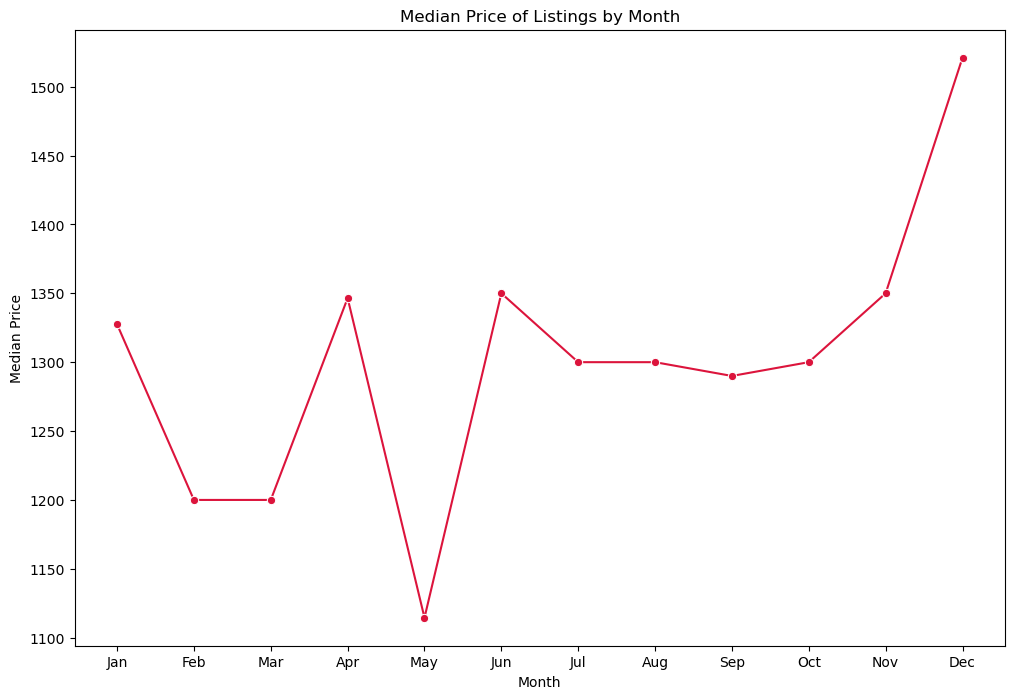

In [30]:
import warnings
from pandas.errors import SettingWithCopyWarning

# Suppress the SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Convert the last_review column to datetime format
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")

# Filter out rows where last_review is the default date
df_filtered = df[df["last_review"] != pd.Timestamp("1970-01-01")]

# Extract the month and year from the last review date for analysis
df_filtered.loc[:, "review_month"] = df_filtered["last_review"].dt.month
df_filtered.loc[:, "review_year"] = df_filtered["last_review"].dt.year

# Group by month and calculate the average price and the number of reviews per month
monthly_trends = df_filtered.groupby("review_month").agg(
    average_price=("price", "median"),
    total_reviews=("number_of_reviews", "sum"),
    average_availability=("availability_365", "median")
).reset_index()

# Average Price by Month
plt.figure(figsize=(12, 8))
sns.lineplot(data=monthly_trends, x="review_month", y="average_price", marker="o", color="#DC143C")
plt.title("Median Price of Listings by Month")
plt.xlabel("Month")
plt.ylabel("Median Price")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

**Insight:**<br>
The graph clearly shows a seasonal pattern in average listing prices. There's a noticeable peak in December, suggesting increased demand and higher prices during this period. This is likely due to peak travel seasons, holidays, and events.

**Hypothesis Testing 2:** To understand if there is a relationship between the number of reviews and the seasonality of Airbnb listings.
- **H0** : There is no significant seasonal difference in the number of reviews.
- **H1** : There is a significant seasonal difference in the number of reviews.

In [31]:
# Grouping data by month and extracting number of reviews for each month
review_groups = [df[df['month'] == month]['number_of_reviews'] for month in df['month'].unique()]

# Perform Kruskal-Wallis test for number of reviews
review_kruskal = stats.kruskal(*review_groups)

# Display Kruskal-Wallis test result for reviews
print(f"Kruskal-Wallis H-statistic for Reviews: {review_kruskal.statistic}, p-value: {review_kruskal.pvalue}")

# Interpretation of results
if review_kruskal.pvalue <= 0.05:
    print("pvalue < 0.05. Reject Ho. There is a significant seasonal difference in the number of reviews.")
else:
    print("pvalue > 0.05. Except Ho. There is no significant seasonal difference in the number of reviews.")

Kruskal-Wallis H-statistic for Reviews: 641.341395856773, p-value: 1.990735655938196e-130
pvalue < 0.05. Reject Ho. There is a significant seasonal difference in the number of reviews.


**Conclusion:**<br>
This means that there is strong evidence to suggest that the number of reviews varies significantly across different months of the year.

**Analysis Reviews and Seasonal Fluctuations**

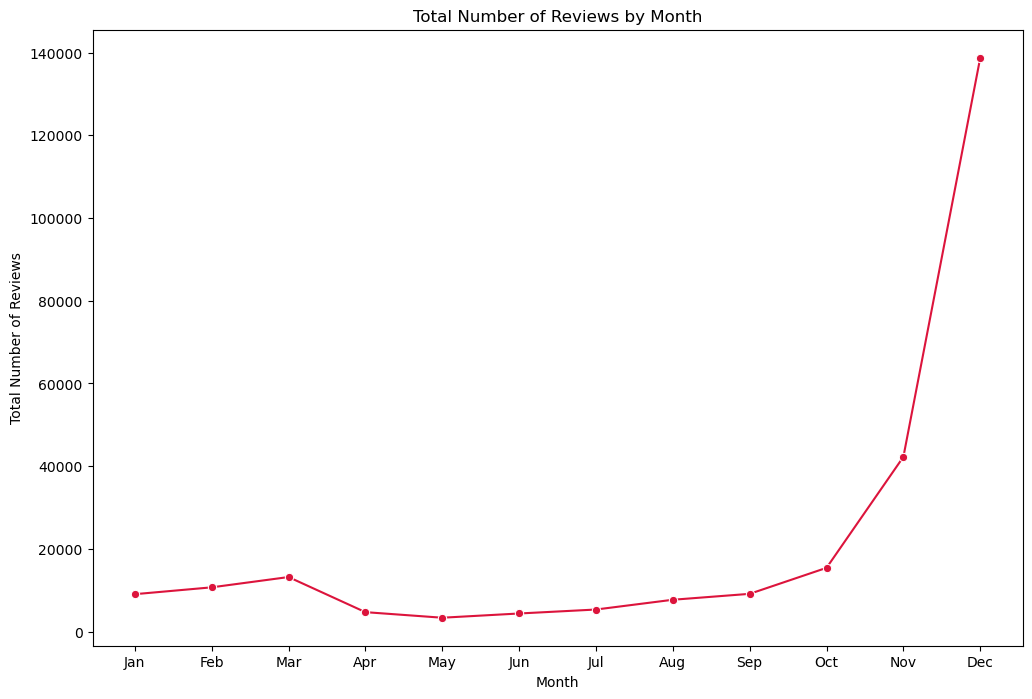

In [32]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=monthly_trends, x="review_month", y="total_reviews", marker="o", color="#DC143C")
plt.title("Total Number of Reviews by Month")
plt.xlabel("Month")
plt.ylabel("Total Number of Reviews")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

**Insight:**<br>
There's a distinct peak in December, suggesting a surge in Airbnb activity during the holiday season.
The months leading up to December also see a gradual increase in reviews, indicating a buildup to the peak season.
Months like April, May, and June have significantly fewer reviews, indicating a potential off-peak season. This could be due to factors like weather conditions, school holidays, or other seasonal events. Hosts can adjust their pricing strategies to capitalize on peak seasons and offer discounts during off-peak periods to attract more guests.

**Hypothesis Testing 3:** To evaluate if the availability of Airbnb listings fluctuates throughout the year.
- **H0** : There is no significant seasonal difference in availability.
- **H1** : There is a significant seasonal difference in availability.

In [33]:
# Grouping data by month and extracting availability values for each month
availability_groups = [df[df['month'] == month]['availability_365'] for month in df['month'].unique()]

# Perform Kruskal-Wallis test for availability
availability_kruskal = stats.kruskal(*availability_groups)

# Display Kruskal-Wallis test result for availability
print(f"Kruskal-Wallis H-statistic for Availability: {availability_kruskal.statistic}, p-value: {availability_kruskal.pvalue}")

# Interpretation of results
if availability_kruskal.pvalue <= 0.05:
    print("pvalue < 0.05. Reject Ho. There is a significant seasonal difference in availability.")
else:
    print("pvalue > 0.05. Except Ho. There is no significant seasonal difference in availability.")

Kruskal-Wallis H-statistic for Availability: 17.74191820715117, p-value: 0.08776545830889113
pvalue > 0.05. Except Ho. There is no significant seasonal difference in availability.


**Conclusion:**<br>
It indicates that there is no statistically significant seasonal difference in the availability of listings across the months analyzed. This suggests that the availability of listings does not vary significantly with the seasons, and hosts may not need to adjust their availability strategies based on seasonality.

**Analysis Availability and Seasonal Fluctuations**

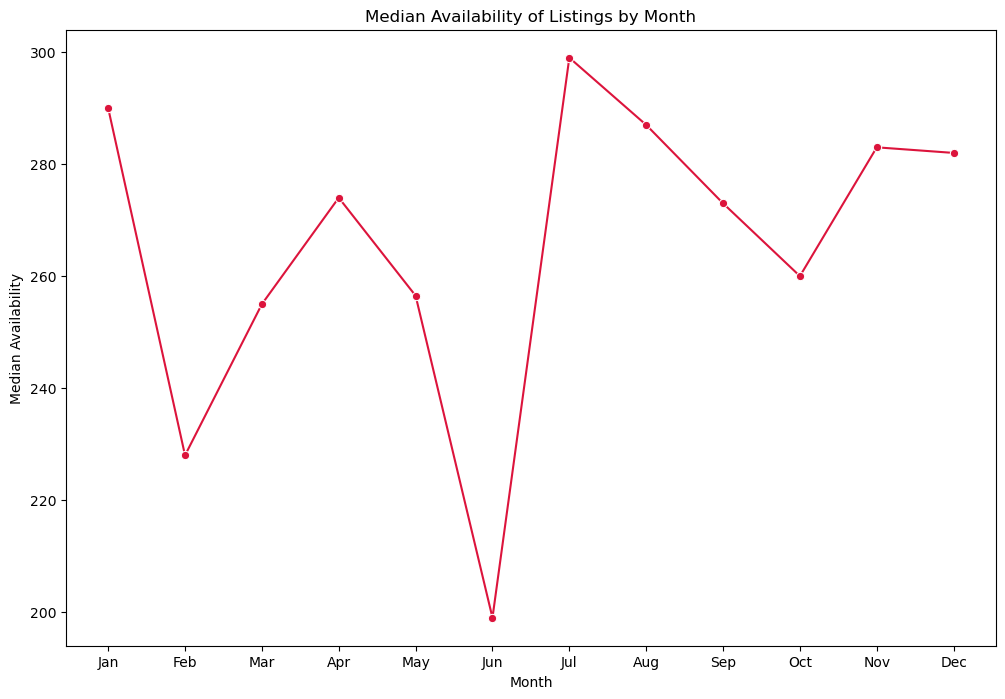

In [35]:
# Average Availability by Month
plt.figure(figsize=(12, 8))
sns.lineplot(data=monthly_trends, x="review_month", y="average_availability", marker="o", color="#DC143C")
plt.title("Median Availability of Listings by Month")
plt.xlabel("Month")
plt.ylabel("Median Availability")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

**Insight:**<br>
The high availability of listings in November and December indicates untapped market potential. This could be caused by several factors, such as:<br>
- **Seasonal Demand:** The demand for accommodations in these locations may tend to decrease towards the end of the year.
- **High Competition:** The large number of available listings increases competition among property owners, making it difficult to attract guests.
- **Pricing Strategy:** Some property owners may not have optimized their pricing strategies, making it harder to capture guest interest.